# Interpreting Image Classification of Keras InceptionV3

This notebook examines the predictions of an image classfifier (DNN InceptionV3) using two interpretation methods:

> * LimeImageExplainer (LIME)
> * Class Activation Maps (CAM)

* First, LIME and CAM will be applied on a single prediction to make their concepts easier to understand. 
* In the following section, both methods are systematically applied to a group of predictions and compared using their masks
* The Images used in this notebook can be downloaded from ImageNet: [*Download from here*](http://image-net.org/imagenet_data/urls/imagenet_fall11_urls.tgz)

In [7]:
#process not on GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

## Loading packages

In [8]:
# Keras
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# Tools requiered for visualizing and processing
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
model_InceptionV3 = InceptionV3(weights = 'imagenet')

## Getting started with a single prediction of the model

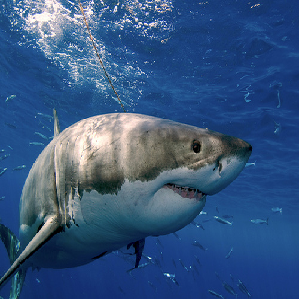

In [11]:
# Load image and scale to 299x299
image_raw = load_img("/home/common_files/datasets/imagenet/pictures/n01484850/n01484850_10798.jpg",target_size = (299,299))
image_raw

In [12]:
# Preprocess image in an array to make it compatible with the Keras model and reshape it.
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [13]:
# Predict label of image
prediction = model_InceptionV3.predict(image)
pd.DataFrame(decode_predictions(prediction, top=3)[0],columns=['col1','class','probability']).iloc[:,1:]

class  probability
0  great_white_shark     0.938497
1        tiger_shark     0.001046
2         grey_whale     0.000489

## Loading LIME

In [14]:
import lime
from lime.lime_image import LimeImageExplainer
# Requiered segmentation package for creating superpixel of image
from skimage.segmentation import mark_boundaries, quickshift
import numpy as np

### Create explaination

In [18]:
explainer = LimeImageExplainer()

Number of superpixel:  65


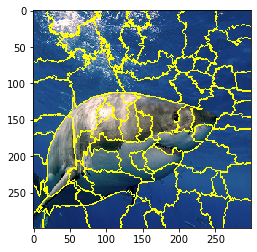

In [19]:
# This part is optional and is listed to make clear the idea behind LimeImageExplainer. This means Lime does this automatically in the back.
# Lime is creating superpixels using the segmentation algorithm quickshift like below, and predicts the image user-defined-times by turning superpixel on and off

segments = quickshift(image_raw, kernel_size=4, max_dist=200, ratio=0.2,random_seed=42)
superpixel = mark_boundaries(image_raw, segments)
plt.imshow(superpixel)
print('Number of superpixel: ',len(np.unique(segments)))

In [20]:
# pass image as (299,299,3)-Array 299x299Pixel in RGB
# top_labels = 3 -> create explanation for top three labels predicted by the model for image
# num_samples = 500 -> create 500 similiar pictures by turning superpixel on and off 
# random_seed = 42 -> for reproducability

explanation = explainer.explain_instance(image[0], model_InceptionV3.predict, top_labels=3, num_samples=500, random_seed=42)

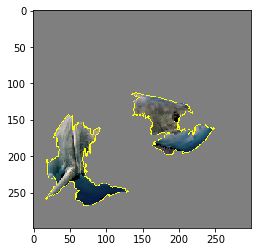

In [21]:
# Show top five (by default) Superpixel with positive weights supported decision making

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True,  hide_rest=True)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)

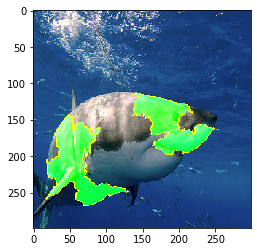

In [22]:
# explanation.top_labels[0] -> index of highest probable predicted class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,   hide_rest=False)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)


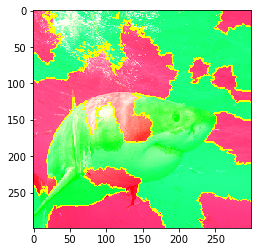

In [23]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=len(np.unique(segments)),hide_rest=False)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)

### Create explanations for a group of predictions

* We predicted 810 992 images (from the ImageNet database) without retraining the model
* Result: Accuracy of 86.9 %
* At the end we created a dataset containing all false predicted images


In [25]:
results_images_df = pd.read_hdf('results-inceptionv3-1.h5',key='pictures')
results_images_df.head(5)

label_id label_name1 label_name2  prediction_id prediction_name1  \
0         0   n01440764       tench            651        n03761084   
0         0   n01440764       tench            389        n02514041   
0         0   n01440764       tench             33        n01664065   
0         0   n01440764       tench            391        n02536864   
0         0   n01440764       tench            719        n03935335   

  prediction_name2                      file_name  confidence_in_prediction  \
0        microwave  n01440764/n01440764_10028.jpg                  0.689906   
0       barracouta  n01440764/n01440764_10030.jpg                  0.908541   
0       loggerhead   n01440764/n01440764_1024.jpg                  0.087677   
0             coho  n01440764/n01440764_10553.jpg                  0.294498   
0       piggy_bank  n01440764/n01440764_10744.jpg                  0.944047   

   prediction_in_top_5  confidence_in_label  confidence_difference  
0                False             0.006450               0.683456  
0                False             0.008006               0.900535  
0                False             0.057672               0.030005  
0                False             0.022437               0.272061  
0                False             0.005714               0.938332

In [26]:
%%html
<style>
table {float:left}
</style>

### Columns of dataset explained

| Column | Explanation |
| --- | --- |
| label_id | index of actual label |
| label_name1 | encoded actual label |
| label_name2  | decoded actual label |
| prediction_id | index of predicted label |
| prediction_name1 | encoded predicted label |
| prediction_name2 | decoded predicted label |
| file_name | directory of image |
| confidence_in_prediction | probability for predicted label by model |
| prediction_in_top_5 | True, if actual label is in top five of predicted classes, otherwise False |
|confidence_in_label   | probability for actual label predicted by model|
confidence_difference   |confidence_in_prediction - confidence_in_label|

### Define methods for codes above

In [27]:
# To load images
def get_image(image_dir):
    image = load_img("/home/common_files/datasets/imagenet/pictures/"+image_dir,target_size = (299,299))
    return image    

In [28]:
# Preprocess image in an array to make it compatible with the Keras model and reshape it. 
def preprocess_image(image_raw):
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image[0]

In [ ]:
# Create explanation of Image
def explanation_for_instance(image,model):
    explanation = explainer.explain_instance(image,model.predict,top_labels = 1,num_samples=500,random_seed=42)
    return explanation

In [33]:
# Mask explanation and return top ten superpixel for most probable prediction of model and hide rest of image
def get_explained_image(explanation, positive_only, hide_rest):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = positive_only, num_features=10, hide_rest=hide_rest)
    bounderies = mark_boundaries(temp /2 + .5,mask)
    return bounderies

### Create explanations in loop

* We want to create explanations for only images where confidence_difference is higher than 0.98 since we have more than 100 000 false predictions 
* And it takes to much time generate an explanation for an image

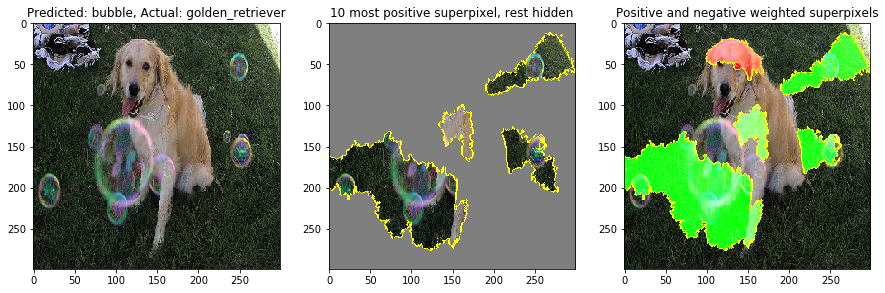

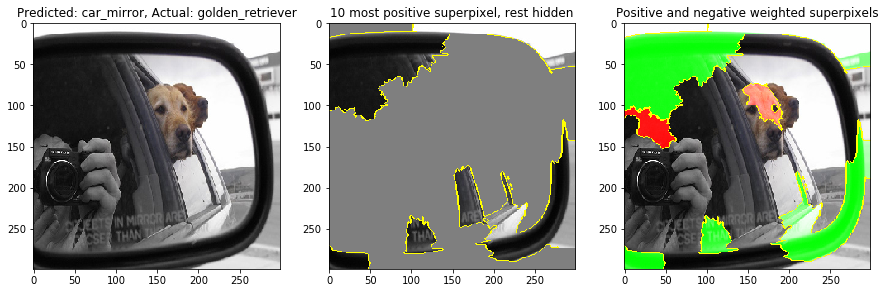

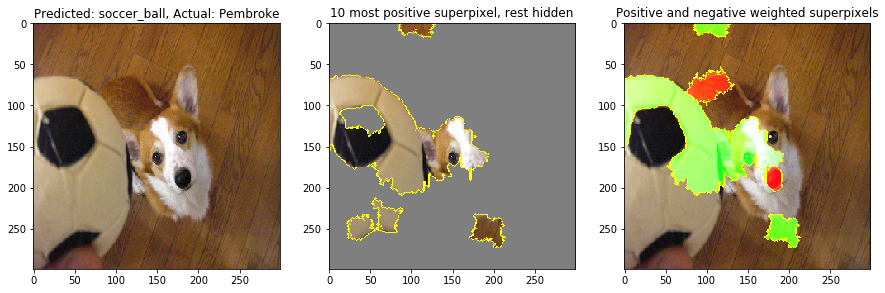

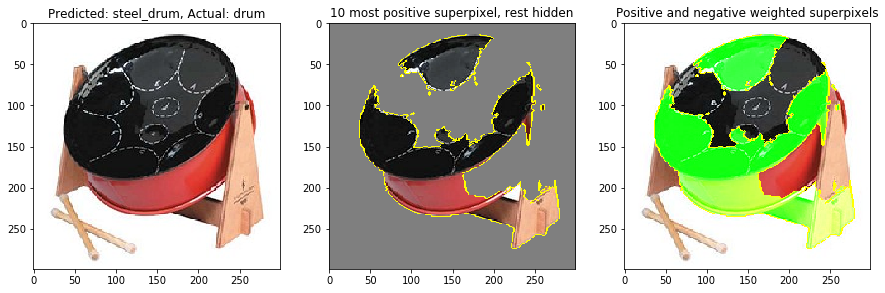

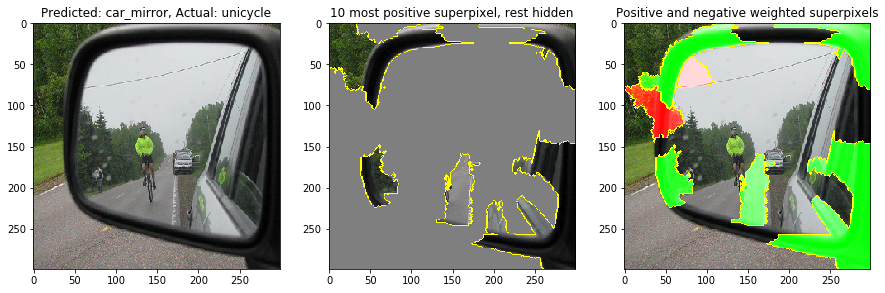

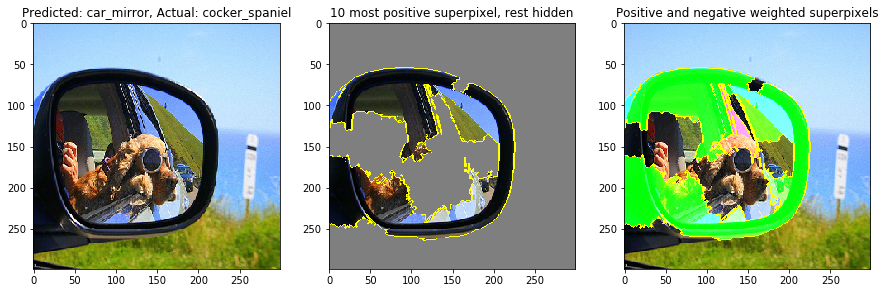

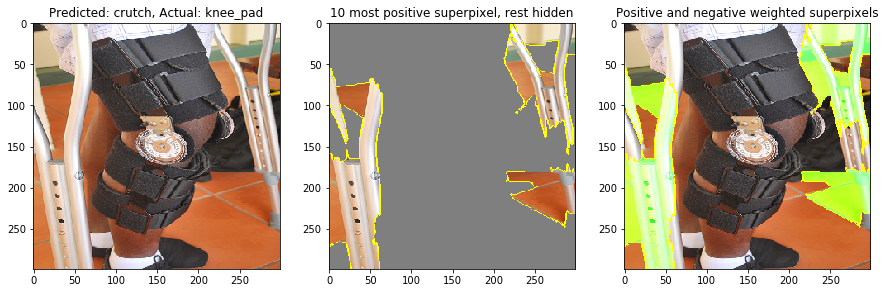

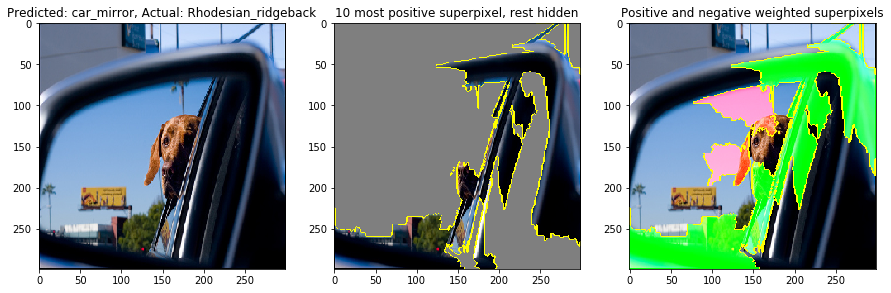

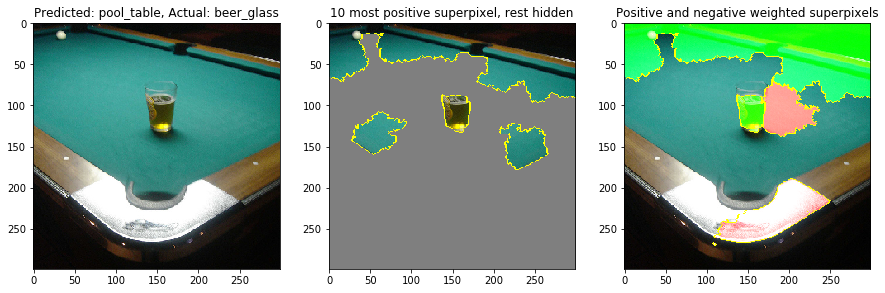

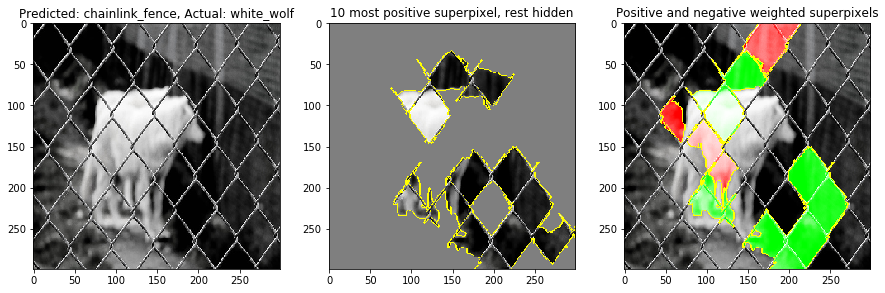

In [34]:
# Order dataframe by confidence_difference descending to make iteration more efficent
results_images_df = results_images_df.sort_values(['confidence_difference'], ascending=False)

# Create explanation in loop

for i in range(len(results_images_df)):
    
    file_name = results_images_df.iloc[i]['file_name']
    image_raw = get_image(file_name)
    image = preprocess_image(image_raw)
    # Create explanation for predicted label
    explanation = explanation_for_instance(image, model_InceptionV3)
    # get explained image with 10 positive weighted superpixel and hide rest
    explained_image_positive_and_hidden = get_explained_image(explanation, positive_only = True, hide_rest= True)
    # get explained image with 10 positive or negative weigthed superpixel, hide_rest = False
    explained_image_pos_neg = get_explained_image(explanation, positive_only = False, hide_rest= False)
    
    #plt.savefig('../Output_Images/Predicted_ {}, Actual_ {}'.format(results_images_df.iloc[i]['prediction_name2'],results_images_df.iloc[i]['label_name2']))
    
    #plot only first 10
    if i < 10:
        
        fig, ax = plt.subplots(1,3, figsize = (15,15))
        ax[0].imshow(image_raw)
        ax[0].set_title('Predicted: {}, Actual: {}'.format(results_images_df.iloc[i]['prediction_name2'],results_images_df.iloc[i]['label_name2']), fontsize =12)
        ax[1].imshow(explained_image_positive_and_hidden)
        ax[1].set_title('10 most positive superpixel, rest hidden')
        ax[2].imshow(explained_image_pos_neg)
        ax[2].set_title('Positive and negative weighted superpixels')
        plt.show()
    
    if results_images_df.iloc[i]['confidence_difference'] < 0.98:
        break
    
    if i >=10:
        break

## LIME vs. Class Activation Maps

* In this section Class Activation Maps are generated and compared with the results of the LimeImageExplainer.

* Class Activation Maps are simple to implement and can help to get the discriminative image regions used by a CNN to identify a specific class in the image. 

* Class Activation Maps are often called as Attention Maps

### Get Class Activation Map for a single prediction

In [20]:
# import keras-vis
import vis
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam
from keras import activations
from PIL import Image
import os

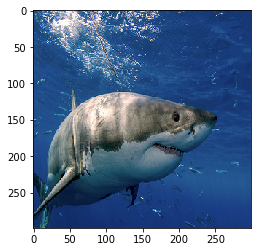

In [21]:
image_raw = load_img("/home/common_files/datasets/imagenet/pictures/n01484850/n01484850_10798.jpg",target_size = (299,299))
plt.imshow(image_raw)

In [22]:
#Preprocess input
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [27]:
# predict
prediction = model_InceptionV3.predict(image)
print(pd.DataFrame(decode_predictions(prediction, top=3)[0],columns=['col1','class','probability']).iloc[:,1:])
# get corrosponding imagenet index for prediction
argmax = np.argmax(prediction[0])
print('\nImageNet Index for prediction: ',argmax)


               class  probability
0  great_white_shark     0.938497
1        tiger_shark     0.001046
2         grey_whale     0.000489

ImageNet Index for prediction:  2


In [28]:
# get last layer
prediction_layer = model_InceptionV3.get_layer('predictions')
prediction_layer

In [29]:
# get index of last layer
prediction_layer_idx = utils.find_layer_idx(model_InceptionV3, 'predictions')
prediction_layer_idx

312

(299, 299, 3)

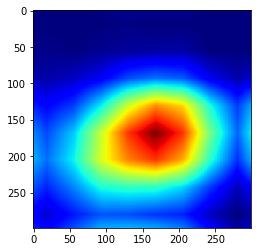

In [30]:
# filter_indices is the corresponding label index for great_white_share
cam = visualize_cam(model=model_InceptionV3, layer_idx=prediction_layer_idx, filter_indices=argmax, seed_input=image)
plt.imshow(cam)
cam.shape

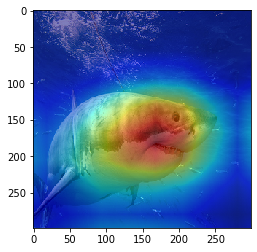

In [32]:
plt.imshow(overlay(np.array(image_raw),cam, alpha=0.5))

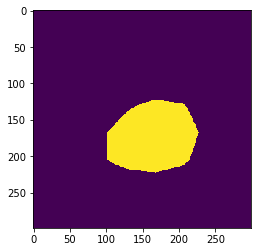

In [34]:
# Get the red area of the attention_map (most positive area for classification of cnn)
# initialize 3D-array of zeros 299x299Pixel RGB
cam_mask = np.zeros((299,299))

# fill array, where blue channel is 0
mask = cam[:,:,2] == 0

# Set to 1 the pixels where mask is True
cam_mask[mask] = 1
plt.imshow(cam_mask)

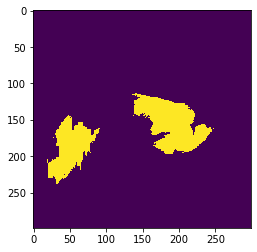

In [35]:
# get lime mask for top 5 superpixel of actual label

#first create explanation the image index of great white shark (labels = (2,))
explanation = explainer.explain_instance(image[0], model_InceptionV3.predict,num_samples = 500, labels = (argmax,), top_labels = None)
temp, lime_mask = explanation.get_image_and_mask(argmax, positive_only = True,  hide_rest = True)
boundaries = mark_boundaries(temp / 2 + .5, lime_mask)
plt.imshow(lime_mask)


### Compare both masks

![Intersection_LIME_CAM](Intersection_LIME_CAM.png)


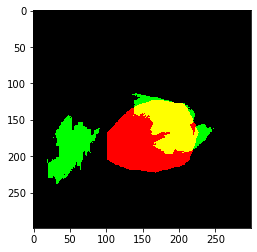

In [36]:
# Compare both masks
masks = np.zeros((299,299,3))
masks[:,:,0] = cam_mask
masks[:,:,1] = lime_mask
plt.imshow(masks)

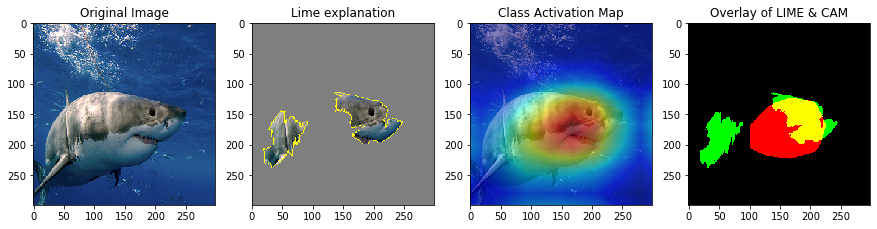

Overlay of LIME and Class Activation Map:

Pixel in intersection (Yellow): 3973 
Pixel only in CAM (Red): 	5754 
Pixel only in LIME (Green): 	4042 
Match in percentage (Yellow): 	0.2885467354201467


In [38]:
# Pixel in intersection (Yellow)
pixel_intersection = ((lime_mask + cam_mask) == 2).sum()
# Totalpixel_attentionMap without intersection
pixel_cam = (cam_mask == 1).sum() - pixel_intersection 
# Totalpixel Lime without intersection
pixel_lime = (lime_mask == 1 ).sum() - pixel_intersection

# Get match in percentage (Yellow)
match_in_percent = pixel_intersection / (pixel_lime + pixel_cam + pixel_intersection)

fig, ax = plt.subplots(1,4, figsize = (15,15))

ax[0].imshow(image_raw)
ax[0].set_title('Original Image')
ax[1].imshow(boundaries)
ax[1].set_title('Lime explanation')
ax[2].imshow(overlay(np.array(image_raw),cam, alpha=0.5))
ax[2].set_title('Class Activation Map')
ax[3].imshow(masks)
ax[3].set_title('Overlay of LIME & CAM')


plt.show()
print('Overlay of LIME and Class Activation Map:\n')
print('Pixel in intersection (Yellow): {} \nPixel only in CAM (Red): \t{} \nPixel only in LIME (Green): \t{} \nMatch in percentage (Yellow): \t{}'.format(pixel_intersection,pixel_cam, pixel_lime,match_in_percent))

## Get code above in methods and create explanations for group of predictions

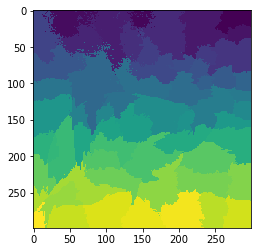

In [39]:
plt.imshow(explanation.segments)

In [65]:
def get_mask_lime(path,image_index):
    #Preprocess input
    image_raw = load_img(path,target_size = (299,299))
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    explanation = explainer.explain_instance(image[0], model_InceptionV3.predict,num_samples = 500, labels = (image_index,), top_labels = None)
    temp, lime_mask = explanation.get_image_and_mask(image_index, positive_only = True,  hide_rest = True)
    boundaries = mark_boundaries(temp / 2 + .5, lime_mask)
    #plt.imshow(lime_mask)
    
    return lime_mask, boundaries

In [66]:
def get_mask_cam(path,image_index):
    
    image_raw = load_img(path,target_size = (299,299))
    # Preprocess image in an array to make it compatible with the Keras model and reshape it.
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    cam_mask = np.zeros((299,299))
    cam = visualize_cam(model_InceptionV3, layer_idx=prediction_layer_idx, filter_indices=image_index, seed_input=image)
    # fill array, where blue channel is 0
    mask = cam[:,:,2] == 0
    # Set to 1 the pixels where mask is True
    cam_mask[mask] = 1
    
    return cam_mask, cam

In [67]:
def compare_masks(lime_mask,cam_mask):
    # Pixel in intersection (Yellow)
    # Compare both masks
    masks = np.zeros((299,299,3))
    masks[:,:,0] = cam_mask
    masks[:,:,1] = lime_mask

    pixel_intersection = ((lime_mask + cam_mask) == 2).sum()
    # Totalpixel_attentionMap without intersection
    pixel_cam = (cam_mask == 1).sum() - pixel_intersection 
    # Totalpixel Lime without intersection
    pixel_lime = (lime_mask == 1 ).sum() - pixel_intersection
    # Get match in percentage (Yellow)
    match_in_percent = pixel_intersection / (pixel_lime + pixel_cam + pixel_intersection)

    return masks,pixel_intersection,pixel_lime,pixel_cam, match_in_percent

In [68]:
import json
classJSON = "/home/visalf/.keras/models/imagenet_class_index.json"

with open(classJSON) as json_file:
    label_list = json.load(json_file)
invers_label_list = {}
for class_ID, value in label_list.items():
    invers_label_list[value[0]] = int(class_ID)

In [69]:
def get_prediction(path):
    image_raw = load_img(path, target_size = (299,299))
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    prediction = model_InceptionV3.predict(image)
    predicted_label = decode_predictions(prediction)[0][0][0]
    predicted_label_name = decode_predictions(prediction)[0][0][1]
    return prediction[0], predicted_label, predicted_label_name

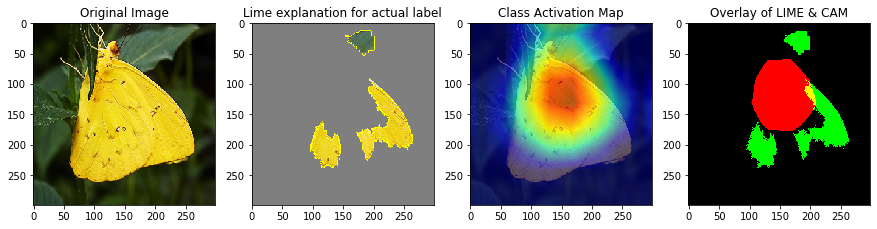

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 322 
Pixel only in CAM (Red): 	9209 
Pixel only in LIME (Green): 	7286 
Match in percentage (Yellow): 	0.019147291431289765


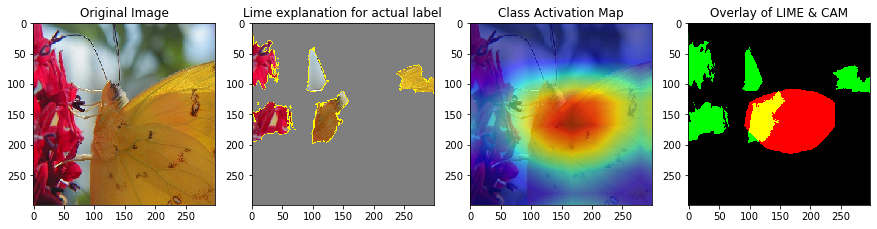

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 2558 
Pixel only in CAM (Red): 	9853 
Pixel only in LIME (Green): 	8286 
Match in percentage (Yellow): 	0.12359279122578151


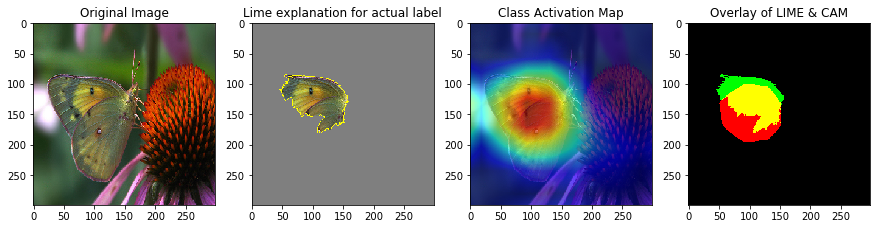

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 4360 
Pixel only in CAM (Red): 	3252 
Pixel only in LIME (Green): 	1823 
Match in percentage (Yellow): 	0.4621091679915209


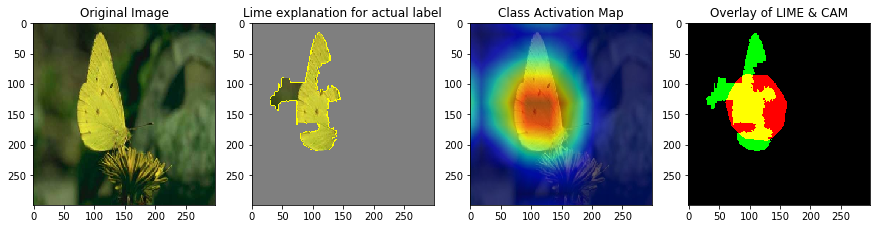

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 4792 
Pixel only in CAM (Red): 	3743 
Pixel only in LIME (Green): 	3498 
Match in percentage (Yellow): 	0.3982381783428904


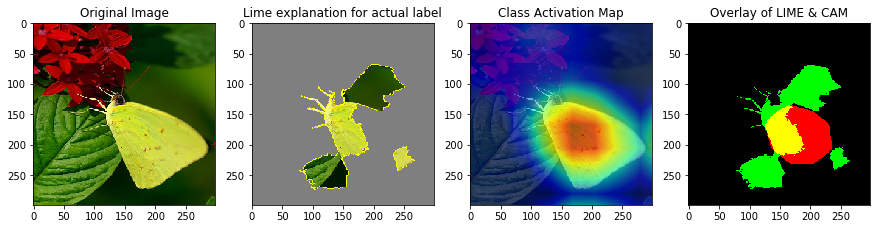

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 3158 
Pixel only in CAM (Red): 	4837 
Pixel only in LIME (Green): 	9272 
Match in percentage (Yellow): 	0.1828922221578734


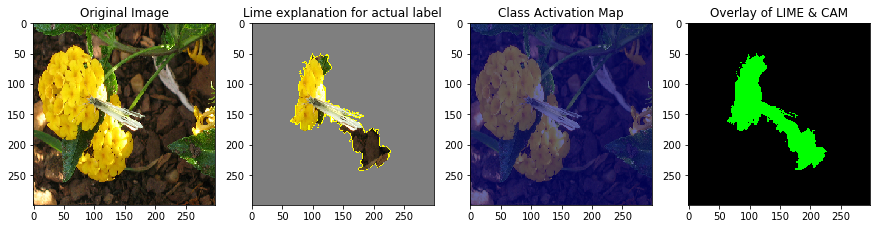

Overlay of LIME and Class Activation Map:

Predicted label: 		coral_fungus 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 0 
Pixel only in CAM (Red): 	0 
Pixel only in LIME (Green): 	9012 
Match in percentage (Yellow): 	0.0


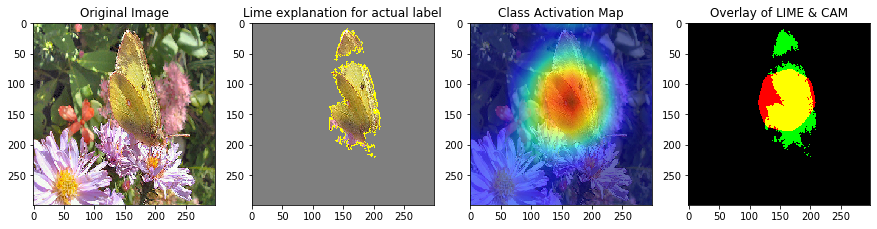

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 5615 
Pixel only in CAM (Red): 	1831 
Pixel only in LIME (Green): 	3010 
Match in percentage (Yellow): 	0.5370122417750574


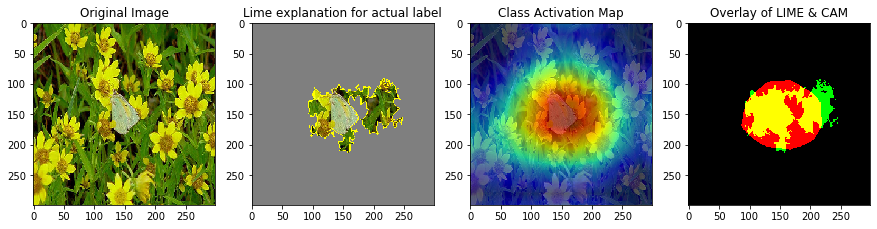

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 6939 
Pixel only in CAM (Red): 	4728 
Pixel only in LIME (Green): 	1573 
Match in percentage (Yellow): 	0.5240936555891239


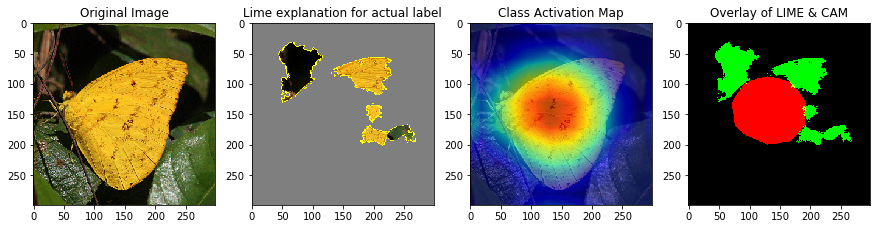

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 83 
Pixel only in CAM (Red): 	10510 
Pixel only in LIME (Green): 	8793 
Match in percentage (Yellow): 	0.004281440214587847


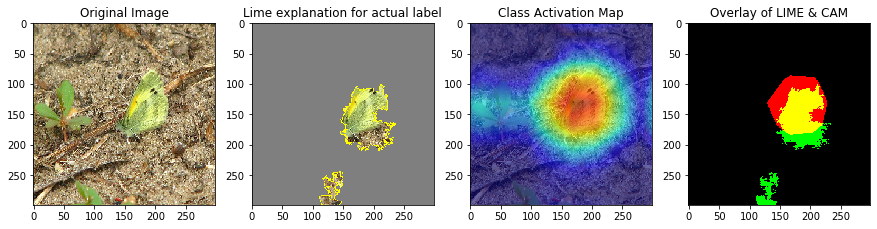

Overlay of LIME and Class Activation Map:

Predicted label: 		sulphur_butterfly 
Actual label: 			sulphur_butterfly 
Pixel in intersection (Yellow): 4105 
Pixel only in CAM (Red): 	3144 
Pixel only in LIME (Green): 	2497 
Match in percentage (Yellow): 	0.4211984403857993


In [ ]:
import os
base_path = '/home/common_files/datasets/imagenet/pictures'
resultsDF = pd.DataFrame()
i = 0
for dir_, subfolder, file_name in os.walk(base_path):
    
    for class_name in subfolder:
        class_paths = os.path.join(dir_,class_name) 

        for dir_, s, file_name in os.walk(class_paths):

            for file in file_name:
                i += 1
                #print('file: ', file)
                path_to_image = os.path.join(dir_, file)
                image_raw = load_img(path_to_image, target_size=(299,299))
                image_index = invers_label_list[class_name]
                actual_label_name = label_list[str(image_index)][1]
                lime_mask, boundaries = get_mask_lime(path_to_image, image_index)
                cam_mask, cam_map = get_mask_cam(path_to_image, image_index)
                both_masks, pixel_intersection, pixel_lime, pixel_cam, match_in_percent = compare_masks(lime_mask, cam_mask)
                prediction,predicted_label,predicted_label_name = get_prediction(path_to_image)
                
                data = {
                    
                    'lime_mask' : [lime_mask],
                    'cam_mask' : [cam_mask],
                    'file_name': [file],
                    'image_class_ID' : [image_index],
                    'percentage_lime_in_cam' : [match_in_percent*100],
                    'pixel_intersection_lime_cam' : [pixel_intersection],
                    'pixel_only_lime' : [pixel_lime],
                    'pixel_only_lime' : [pixel_cam],
                    'actual_label' : [class_name],
                    'actual_label_name' : [actual_label_name],
                    'predicted_label': [predicted_label],
                    'predicted_label_name' : [predicted_label_name],
                    'prediction' : [prediction]
                    
                }
                
                resultsDF = resultsDF.append(pd.DataFrame(data),ignore_index = False)
                #plot only first 10
                if i <= 10:
                    fig, ax = plt.subplots(1,4, figsize = (15,15))
                    ax[0].imshow(image_raw)
                    ax[0].set_title('Original Image')
                    ax[1].imshow(boundaries)
                    ax[1].set_title('Lime explanation for actual label')
                    ax[2].imshow(overlay(np.array(image_raw),cam_map, alpha=0.4))
                    ax[2].set_title('Class Activation Map')
                    ax[3].imshow(both_masks)
                    ax[3].set_title('Overlay of LIME & CAM')
                    plt.show()
                    
                    print('Overlay of LIME and Class Activation Map:\n')
                    print('Predicted label: \t\t{} \nActual label: \t\t\t{} \nPixel in intersection (Yellow): {} \nPixel only in CAM (Red): \t{} \nPixel only in LIME (Green): \t{} \nMatch in percentage (Yellow): \t{}'.
                          format(predicted_label_name,actual_label_name,pixel_intersection,pixel_cam, pixel_lime,match_in_percent))

        resultsDF.to_hdf('results_lime_cam.h5', key = class_name)